# Long Short-Term Memory with Natural Language Processing Component for Stock Movement Prediction

### Import libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU, PReLU, GlobalAveragePooling1D
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from math import sqrt
from sklearn.metrics import mean_squared_error
import mplfinance as mpf
import matplotlib.dates as mdates
from news_test import daily_sentiment
plt.style.use('seaborn-deep')






### Data processing

In [2]:
#specify the filename of the company to get the stock values
filename = 'AAPL.csv'
ticker = filename.split('.')[0] 
#data_clean parses the stock so that the first entrance is 2015-01-01
df = pd.read_csv('./data_clean/' + filename, index_col=0, sep=',')

#parse the data and put it instead of indices
def date_parse(s): 
    d = s.split('-')
    return datetime.date(int(d[0]), int(d[1]), int(d[2]))

df.index = df.index.map(date_parse)

df = df.query('index < datetime.date(2020,1,1)') #the period of query is 2015-01-01 till 2019-12-31

In [3]:
#use news_sentiments.csv to get the sentiment analysis (NLP component) of the specified by its ticker company
#make running sentiment column based on index (date) col
df['sentiment'] = [daily_sentiment(ticker, d) for d in df.index.values]

In [4]:
df

,open,high,low,close,adj close,volume,sentiment
date,,,,,,,
2015-01-02,111.389999,111.440002,107.349998,109.330002,100.216454,53204600,0.104297
2015-01-05,108.290001,108.650002,105.410004,106.250000,97.393181,64285500,0.075262
2015-01-06,106.540001,107.430000,104.629997,106.260002,97.402374,65797100,0.056943
2015-01-07,107.199997,108.199997,106.699997,107.750000,98.768150,40105900,0.057881
2015-01-08,109.230003,112.150002,108.699997,111.889999,102.563072,59364500,0.054941
...,...,...,...,...,...,...,...
2019-12-24,284.690002,284.890015,282.920013,284.269989,283.596924,12119700,0.036205
2019-12-26,284.820007,289.980011,284.700012,289.910004,289.223602,23280300,0.061768
2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500,0.312443


In [5]:
columns_titles = ["open","high", "low", "close", "volume", "sentiment", "adj close"]
df=df.reindex(columns=columns_titles)


In [6]:
#hot encoding could be useful in the future work of LSTM & NLP for stock movements
# for idx, row in df.iterrows():
#     if  df.loc[idx,'sentiment'] >0:
#         df.loc[idx,'sentiment'] = 1
#     elif  df.loc[idx,'sentiment'] <0:
#         df.loc[idx,'sentiment'] = -1
#     else:
        
#         df.loc[idx,'sentiment'] = 0

In [7]:
df

,open,high,low,close,volume,sentiment,adj close
date,,,,,,,
2015-01-02,111.389999,111.440002,107.349998,109.330002,53204600,0.104297,100.216454
2015-01-05,108.290001,108.650002,105.410004,106.250000,64285500,0.075262,97.393181
2015-01-06,106.540001,107.430000,104.629997,106.260002,65797100,0.056943,97.402374
2015-01-07,107.199997,108.199997,106.699997,107.750000,40105900,0.057881,98.768150
2015-01-08,109.230003,112.150002,108.699997,111.889999,59364500,0.054941,102.563072
...,...,...,...,...,...,...,...
2019-12-24,284.690002,284.890015,282.920013,284.269989,12119700,0.036205,283.596924
2019-12-26,284.820007,289.980011,284.700012,289.910004,23280300,0.061768,289.223602
2019-12-27,291.119995,293.970001,288.119995,289.799988,36566500,0.312443,289.113831


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 2015-01-02 to 2019-12-31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       1258 non-null   float64
 1   high       1258 non-null   float64
 2   low        1258 non-null   float64
 3   close      1258 non-null   float64
 4   volume     1258 non-null   int64  
 5   sentiment  1258 non-null   float64
 6   adj close  1258 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.6+ KB


In [9]:
# print(np.var(df['close'] - df['adj close'])) #drop one 

In [10]:
#drop redundant columns, close is similar to adj close and high, volume makes distortion in the data and need to be scaled or dropped
df.drop(['close'], inplace = True, axis = 1)
df.drop(['volume'], inplace = True, axis = 1)
df.drop(['low'], inplace = True, axis = 1)
c_names = [name for name in df.columns]

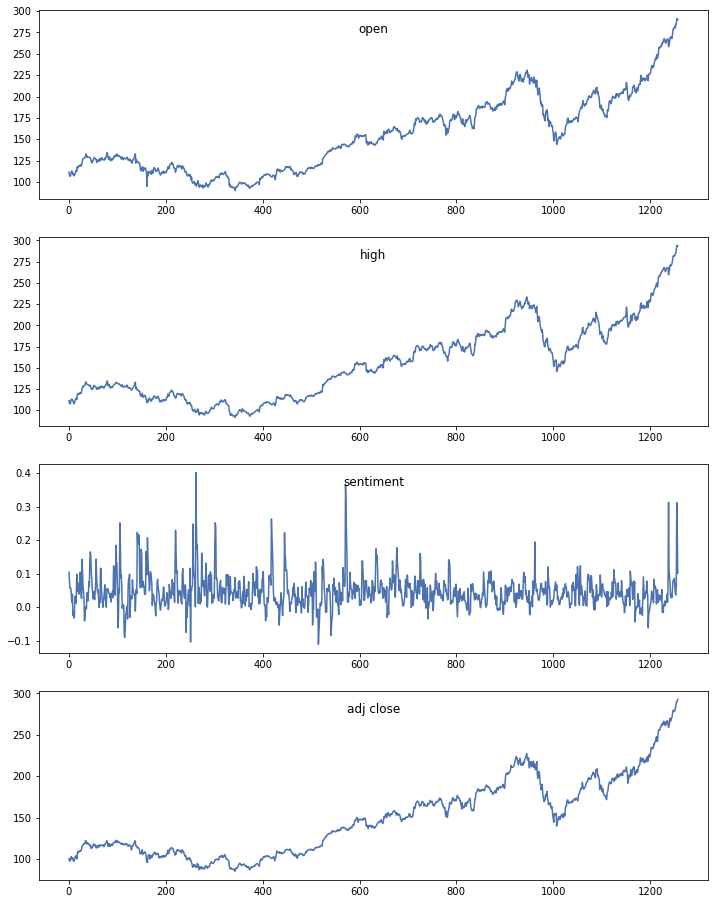

In [11]:
#get the data of the values from the stock market 
cost = df.values

num_f = len(df.columns)

groups = [x for x in range(num_f)]

#plot the data on how the opening, closure, sentiments looked like for a given company
plt.figure(figsize = (12,16))


i = 1
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(cost[:, group])
    plt.title(df.columns[group], y=0.85, loc='center')
    i += 1
plt.show()


Prepare the data for LSTM 

In [12]:
# the stock prices should be reparsed in order for LSTM to be able to work 
#@param data - data frame
#@param columns - column names
#@param  - #days the supervised learning is done on
#@parms  - #days the values of which should be predicted
def prepForLSTM(data, columns, days_to_look=1, days_to_predict=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
   
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # get the data to perform prediction (t-n, ... t-1)
    for i in range(days_to_look, 0, -1):

        cols.append(df.shift(i))
        names += ['%s(t-%d)' % (n, i) for n in columns]
    
    # make a prediction for the days_to_predict (t, t+1, ... t+n)
    for i in range(0, days_to_predict):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % n) for n in columns]
        else:
            names += [('%s(t+%d)' % (n, i)) for n in columns]
   
    aggregation = pd.concat(cols, axis=1)
    aggregation.columns = names
    #get rid of NaN values in the dataset
    if dropnan:
        aggregation.dropna(inplace=True)
    return aggregation

In [13]:
# calculate RMSE
def root_mean_squared_error(y_true, y_pred):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse


In [14]:

# ensure all data is float for the NN
cost = cost.astype('float32')

# Feature normalization
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(cost)
#train based on 21 days
days_range_to_look = 21
days_in_future = 1
total_features = num_f

# reframed the dataset for the supervised learning 
# @param values_scaled - contains the prices
# @param c_names - column names
# @days_range_look - # days to train the model on
# @days_in_future - #days to make a prediction on
reframed = prepForLSTM(values_scaled, c_names, days_range_to_look, days_in_future)

###


print(reframed.head(5))

    open(t-21)  high(t-21)  sentiment(t-21)  adj close(t-21)  open(t-20)  \
21    0.106354    0.097726         0.419644         0.072311    0.090941   
22    0.090941    0.083935         0.363127         0.058722    0.082239   
23    0.082239    0.077904         0.327470         0.058767    0.085521   
24    0.085521    0.081710         0.329296         0.065340    0.095615   
25    0.095615    0.101236         0.323573         0.083606    0.112719   

    high(t-20)  sentiment(t-20)  adj close(t-20)  open(t-19)  high(t-19)  ...  \
21    0.083935         0.363127         0.058722    0.082239    0.077904  ...   
22    0.077904         0.327470         0.058767    0.085521    0.081710  ...   
23    0.081710         0.329296         0.065340    0.095615    0.101236  ...   
24    0.101236         0.323573         0.083606    0.112719    0.106673  ...   
25    0.106673         0.275128         0.084135    0.112371    0.103608  ...   

    sentiment(t-2)  adj close(t-2)  open(t-1)  high(t-1)

Train test split for the supervised learning problem to predict one day in the future

In [15]:
total_observations = days_range_to_look * total_features
#label - column 'adj close'
label = [reframed.columns.to_list().index(col) for col in reframed.columns[total_observations:] if 'open' in col]


# splitting into train and test sets
values = reframed.values

n_train_days = 1000 #%train dataset

train = values[:n_train_days, :]
test = values[n_train_days:, :]
# print(test[:,:n_obs])

In [16]:
train_X, train_y = train[:, :total_observations], train[:, label]
test_X, test_y = test[:, :total_observations], test[:, label]

# reshape input to fit the LSTM network requirements: [n_samples, window, n_features]
train_X = train_X.reshape((train_X.shape[0], days_range_to_look, total_features))
test_X = test_X.reshape((test_X.shape[0], days_range_to_look, total_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1000, 21, 4) (1000, 1) (237, 21, 4) (237, 1)


LSTM Model Training Using Optimal Parameters

In [17]:
#LSTM model training
# the optimal parameters were provided in Nabipour M. "Predicting Stock Market Trends Using Machie Learning"
# the hyperparamteramater tuning took too much of time to find the optimal parameters
#hence, the optimal model provided below
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
        
model = Sequential()
model.add(LSTM(500, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_y.shape[1]))
    
optimizer = keras.optimizers.Adam(lr=0.00005, beta_1=0.9,beta_2 = 0.999, epsilon=None, decay=0.0)

#save only optimal model
checkpoint = ModelCheckpoint('w.hdf5', monitor='val_loss', save_best_only=True)

model.compile(loss='mae', optimizer=optimizer, metrics=['mse', 'mae'])

 # fit data using the optimal parameters highlighted in the paper
history = model.fit(
        train_X, 
        train_y, 
        epochs=50, 
        batch_size=8, 
        validation_split=0.2, 
        verbose=2, 
        shuffle=True,
        callbacks=[early_stop, checkpoint]) 

model.summary()
model.load_weights('w.hdf5')

Epoch 1/50
100/100 - 3s - loss: 0.0503 - mse: 0.0080 - mae: 0.0503 - val_loss: 0.0338 - val_mse: 0.0018 - val_mae: 0.0338
Epoch 2/50
100/100 - 3s - loss: 0.0160 - mse: 4.5957e-04 - mae: 0.0160 - val_loss: 0.0315 - val_mse: 0.0016 - val_mae: 0.0315
Epoch 3/50
100/100 - 2s - loss: 0.0149 - mse: 4.0095e-04 - mae: 0.0149 - val_loss: 0.0302 - val_mse: 0.0014 - val_mae: 0.0302
Epoch 4/50
100/100 - 3s - loss: 0.0147 - mse: 3.8136e-04 - mae: 0.0147 - val_loss: 0.0430 - val_mse: 0.0028 - val_mae: 0.0430
Epoch 5/50
100/100 - 3s - loss: 0.0140 - mse: 3.5349e-04 - mae: 0.0140 - val_loss: 0.0252 - val_mse: 0.0011 - val_mae: 0.0252
Epoch 6/50
100/100 - 3s - loss: 0.0129 - mse: 3.0382e-04 - mae: 0.0129 - val_loss: 0.0276 - val_mse: 0.0013 - val_mae: 0.0276
Epoch 7/50
100/100 - 3s - loss: 0.0124 - mse: 2.7935e-04 - mae: 0.0124 - val_loss: 0.0235 - val_mse: 9.9492e-04 - val_mae: 0.0235
Epoch 8/50
100/100 - 3s - loss: 0.0122 - mse: 2.6683e-04 - mae: 0.0122 - val_loss: 0.0248 - val_mse: 0.0011 - val_mae:

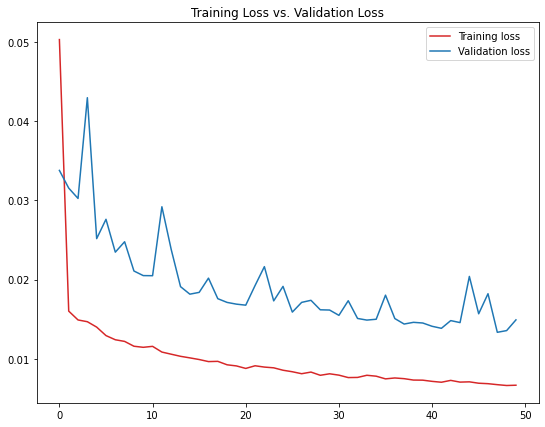

In [19]:
# plot the training history of the optimal model
plt.figure(figsize = (9,7))
plt.title('Training Loss vs. Validation Loss')
plt.plot(history.history['loss'], 'tab:red', label='Training loss')
plt.plot(history.history['val_loss'], 'tab:blue', label='Validation loss')
plt.legend()
plt.show()

Testing of the model

In [20]:

# make a prediction
predicted_label = model.predict(test_X)

# invert scaling
predicted_label_inverse = predicted_label / scaler.scale_[0]
real_label = test_y / scaler.scale_[0]

# reshape back
predicted_label_reshaped = predicted_label_inverse.reshape((-1,1))
real_label_inv = real_label.reshape((-1,1))

# calculate RMSE
rmse = math.sqrt(mean_squared_error(real_label_inv , predicted_label_reshaped))
print('Test set RMSE: %.2f' % rmse)

Test set RMSE: 3.60


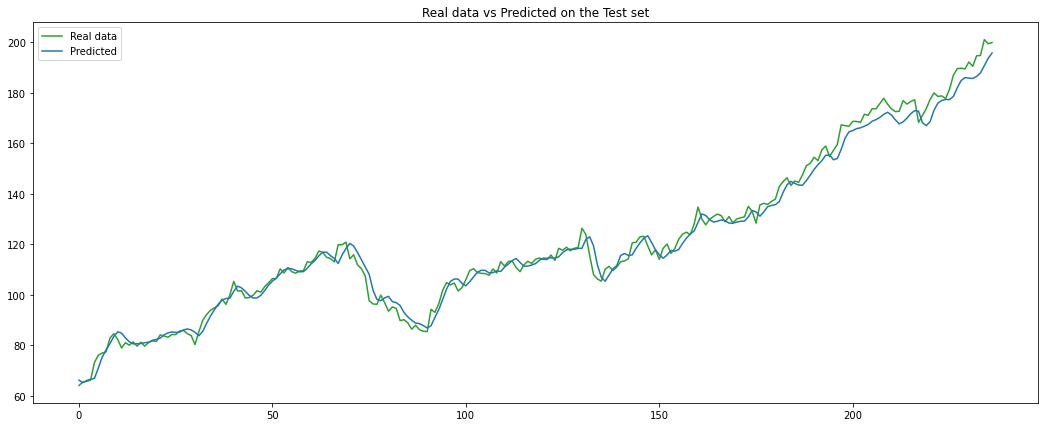

In [21]:
plt.figure(figsize = (18,7))
plt.title('Real data vs Predicted on the Test set')
plt.plot(real_label_inv , 'tab:green', label='Real data')
plt.plot(predicted_label_reshaped, 'tab:blue', label='Predicted')
plt.legend()
plt.show()

Model Evaluation

In [24]:
trainScore = model.evaluate(train_X, train_y, verbose=0)
for i, m in enumerate(model.metrics_names):
    print('Train {0}: {1:5.4f}'.format(m, trainScore[i]))

testScore = model.evaluate(test_X, test_y, verbose=0)
for i, m in enumerate(model.metrics_names):
    print('Test {0}: {1:5.4f}'.format(m, testScore[i]))

Train loss: 0.0080
Train mse: 0.0001
Train mae: 0.0080
Test loss: 0.0140
Test mse: 0.0003
Test mae: 0.0140


Comparison of scaled data - both real and predicted

In [25]:

actual = pd.DataFrame(data=real_label_inv ,  columns=["actual"])
predicted =  pd.DataFrame(data=predicted_label_reshaped)

In [26]:
test_work=df['adj close'].values

In [27]:
actual["predicted"] = predicted

In [28]:
print(actual)

         actual   predicted
0     64.110008   66.233627
1     65.479996   65.220001
2     65.789993   66.091415
3     66.250000   66.564636
4     73.250008   66.927467
..          ...         ...
232  194.690018  186.531784
233  194.820007  187.886948
234  201.119995  190.771591
235  199.459991  193.720490
236  199.929993  195.778259

[237 rows x 2 columns]


As we can see the model predicts the price pretty close. However, it undermines the rise of market stock.